In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


In [9]:
P = 16

In [3]:
def print_mat(MAT, Format = '%.0f '):
    for r in MAT:
        Line = ''
        for c in r:     
            Line += (Format%(c))  
        print(Line)

In [26]:
def Draw_mat(M, colorbar=False,Figsize = [5,5],title = None):
    global P
    plt.figure(figsize = Figsize)
    
    for i in np.arange(0.5,P-1,1.0):
        plt.axhline(y=i, xmin=-0.5, xmax=P-0.5, linewidth=2, color=(0.5,0.5,0.5))
        plt.axvline(x=i, ymin=-0.5, ymax=P-0.5, linewidth=2, color=(0.5,0.5,0.5))
    plt.imshow(M if colorbar else 1-M, cmap = plt.cm.hot, interpolation = 'nearest')
    
    plt.xticks(range(0,M.shape[1],4))
    plt.yticks(range(0,M.shape[0],4))
    
    if title:
        plt.title(title)
    
    if colorbar:
        plt.colorbar(ticks=range((int)(np.max(M))+1), orientation='vertical')
    
    plt.show()
                

In [5]:
# Adjacency Matrix
def Get_ADJ(file_path):
    F = pd.read_csv(file_path, delimiter = ' ', header = None)
    return (F.values).astype('float32')

In [6]:
Adj = Get_ADJ('topology/16k3grid.adj')

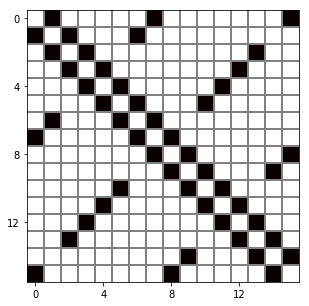

In [28]:
Draw_mat(Adj)

In [10]:
I_P = np.identity(P)

In [11]:
def smoothstep(x):
    R,C = x.shape
    for r in range(R):
        for c in range(C):
            if x[c][r] > 1:
                x[c][r] = 1

In [12]:
def Generate_RouteTree(A_now, D_now):
    global I_P
    D_next = np.matmul(I_P+Adj,D_now)
    smoothstep(D_next)
    return A_now, D_next

In [14]:
from copy import copy

In [22]:
A = copy(Adj)
step = 0
D = np.identity(P)
Routines = []

while (np.min(D) == 0):
    A,D_N = Generate_RouteTree(A,D)
    Routines.append(np.transpose(D_N - D))
    D = D_N
    step += 1

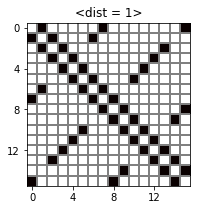

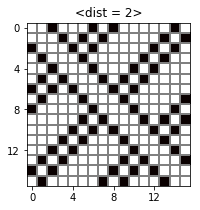

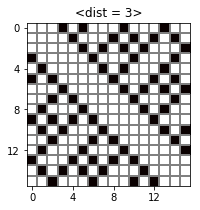

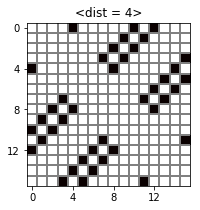

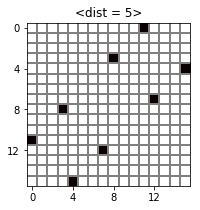

In [27]:
s = 1
for M in Routines:
    Draw_mat(M,Figsize=[3,3],title='<dist = %i>'%s)
    s += 1

In [29]:
import csv

In [31]:
def get_BAMMA(filepath):
    Algorithm = {}
    F = open(filepath,'r')
    FC = csv.reader(F)
    for line in FC:
        if line[0][0] == '@':         # @ node
            rank = (int)(line[0][1:])
            Algorithm[rank] = []   # add node
            i = 1
            while i < len(line):
                if line[i] == 'C': # Compute
                    Vol = (int)(line[i+1])*\
                          (int)(line[i+2])*\
                          (int)(line[i+3])
                    Algorithm[rank].append(('C',Vol))
                    i += 3
                elif line[i] == 'S': # Compute
                    Area = (int)(line[i+2])*(int)(line[i+3])
                    Algorithm[rank].append(('S',(int)(line[i+1]),Area))
                    i += 3
                elif line[i] == 'R': # Compute
                    Area = (int)(line[i+2])*(int)(line[i+3])
                    Algorithm[rank].append(('R',(int)(line[i+1]),Area))
                    i += 3
                    
                    
                i += 1
    F.close()            
    return Algorithm
                

In [33]:
Routine = get_BAMMA('BAMMA/P16_Cannon.csv')

In [34]:
from collections import namedtuple as Ntuple

In [35]:
route_unit = Ntuple('route_unit',['type','value'])

In [36]:
def find_act_comm(Sender,Reciever,adj_M,status,static_Route = None):
    pass

In [73]:
def Real_Routine(Raw_Route,Adj_M):
    # get num of actions vs each node
    Total_P = len(Raw_Route)
    lengths = np.zeros(Total_P,dtype='int32')
    p = 0
    for line in Raw_Route.values():
        lengths[p] = len(line)
        p += 1
    # Result
    Routine = {i:[] for i in range(Total_P)}
    # Nodes Status
    # 0:idle >0:length of queue
    Status = np.zeros(Total_P,dtype='int32')
    
        
    # BFS
    p = 0
    process = np.zeros(Total_P,dtype='int32')
    while True:
        Action = Raw_Route[p][process[p]]
        
        # overhead
        Status -= np.min(Status)

        if Action[0] == 'C':     # Computation
            Routine[p].append(Action)
        elif Action[0] == 'S':   # Send
            #L = find_act_comm(p,Action[1],Adj_M,Status)
            Routine[p].append((Action[0],Action[-1]))
        elif Action[0] == 'R':   # Recieve
            #L = find_act_comm(Action[1],p,Adj_M,Status)
            Routine[p].append((Action[0],Action[-1]))
            
        # add queue
        Status[p] += Action[-1]
        
        # Update
        process[p] += 1
        p = (p+1)%Total_P
        
        # Finished
        if np.max(np.abs(lengths-process)) == 0:
            return Routine
        
    return Routine

In [46]:
# map_rank
def swap_row(M,r1,r2):
    temp_r = M[r2,:]
    M[r2,:] = M[r1,:]
    M[r1,:] = temp_r
    
def swap_col(M,c1,c2):
    temp_c = M[:,c2]
    M[:,c2] = M[:,c1]
    M[:,c1] = temp_c

def map_ranks(Adj_M,Map):
    new_Adj = copy(Adj_M)
    for f,t in Map.items:
        swap_row(new_Adj,f,t)
        swap_col(new_Adj,f,t)
        

# Draw squares

In [89]:
from matplotlib import patches

In [84]:
Color_Table = {
    'C':[0,1,0,1],
    'S':[1,0,0,1],
    'R':[1,1,0,1],
    'W':[0.3,0.3,0.3]
}

In [141]:
def Draw_Route_Table(Routes,title=None):
    global Color_Table
    Total_P = len(Routes)
    Fig1 = plt.figure(figsize=[10,10])
    ax = plt.subplot(111)
    # comp:green | send:red | recv:orange | idle:gray
    x_max = 0
    for p in range(Total_P):
        x = 0
        m_xmax = 0
        for act in Routes[p]:
            ax.add_patch(
                patches.Rectangle((x,p-0.2),act[1],0.4,
                                  fill=True,
                                  ec=None,
                                  fc=Color_Table[act[0]])
            )
            x += act[1]
            m_xmax += act[1]
        if m_xmax > x_max:
            x_max = m_xmax
            
            
    plt.xticks(range(0,x_max,(int)(x_max/10)))  
    plt.yticks(range(Total_P))
    plt.axis([0,x_max,-0.5,Total_P-0.5])
    
    # legends
    legends = [
        patches.Patch(color='green', label='Computation'),
        patches.Patch(color='red', label='Send'),
        patches.Patch(color='yellow', label='Recieve'),
        patches.Patch(color='gray', label='Idle/Wait')
    ]
    
    plt.legend(handles=legends,
               loc='center left', 
               bbox_to_anchor=(1.02, 0.75))
    if title:
        plt.title(title)
    
    plt.show()

In [106]:
RR = Real_Routine(Routine,Adj)

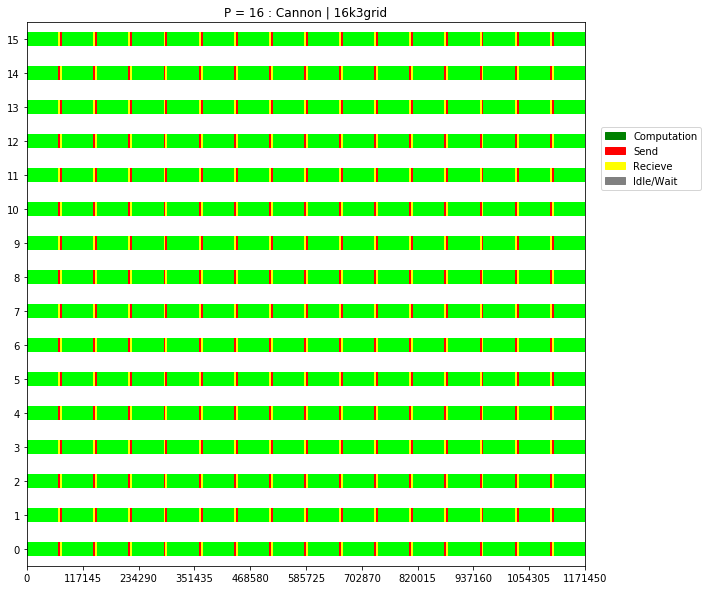

In [142]:
Draw_Route_Table(RR,title='P = 16 : Cannon | 16k3grid')